In [1]:
from collections import namedtuple
import time
import sys

In [2]:
class Edge:
    __slots__ = ['origin', 'destination', 'weight']

    def __init__ (self, origin=None, destination=None):
        self.origin = origin
        self.destination = destination
        self.weight = 1

    def __repr__(self):
        return f"edge: {self.origin} {self.destination} {self.weight}"

class Airport:
    __slots__ = ['code', 'name', 'outweight', 'pageIndex', 'pageRank', 'routes', 'routeHash']

    def __init__(self, code: str = None, name: str = None):
        self.code = code
        self.name = name
        self.outweight = 0
        self.pageIndex = 0
        self.pageRank = 0
        self.routes: list[Edge] = []
        self.routeHash: dict[str, Edge] = dict()

    def __repr__(self):
        return f"{self.code}\t{self.name}"

In [3]:
edgeList: list[Edge] = []# list of Edge
edgeHash: dict[str, Edge] = dict()# hash of edge to ease the match
airportList: list[Airport] = []# list of Airport
airportHash: dict[str, Airport] = dict() # hash key IATA code -> Airport

def readAirports(fd):
    print("Reading Airport file from {0}".format(fd))
    airportsTxt = open(fd, "r")
    cont = 0
    for line in airportsTxt.readlines():
        a = Airport()
        try:
            temp = line.split(',')
            if len(temp[4]) != 5 :
                raise Exception('not an IATA code')
            a.name=temp[1][1:-1] + ", " + temp[3][1:-1]
            a.code=temp[4][1:-1]
        except Exception as inst:
            pass
        else:
            if a.code in airportHash:
                print(f"Skipping duplicate IATA code {a.code}")
                continue
            cont += 1
            airportList.append(a)
            airportHash[a.code] = a
    airportsTxt.close()
    print(f"There were {cont} Airports with IATA code")


def readRoutes(fd):
    print(f"Reading Routes file from {fd}")
    routesTxt = open(fd, "r")
    cont = 0
    weightedCount = 0
    for line in routesTxt.readlines():
        origin: Airport = None
        destination: Airport = None
        try:
            temp = line.split(',')
            if len(temp[2]) != 3 :
                raise Exception('Origin airport not an IATA code')
            if len(temp[4]) != 3 :
                raise Exception('Destination airport not an IATA code')
            
            origin = airportHash.get(temp[2])
            destination = airportHash.get(temp[4])
            if not origin or not destination :
                raise Exception("Airports in route not in aiport list")
        except Exception as inst:
            pass
        else:
            edge = origin.routeHash.get(destination.code)
            origin.outweight += 1
            if edge :
                weightedCount += 1
                edge.weight += 1
            else :
                cont += 1
                edge = Edge(origin, destination)
                edgeList.append(edge)
                edgeHash[f"{edge.origin.code}-{edge.destination.code}"] = edge
                origin.routes.append(edge)
                origin.routeHash[edge.destination.code] = edge
    routesTxt.close()

    sink_nodes = 0
    for airport in airportList:
        if airport.outweight == 0:
            sink_nodes += 1

    print(f"There were {cont} routes with IATA origins and destinations")
    print(f"{sink_nodes} airports have no outgoing routes")

def computePageRanks(damping: float = 0.85, tolerance=1e-6, max_iteratons = 100):
    print("Computing pageranks")
    N = len(airportList)
    INITIAL_RANK = 1.0 / N
    CONSTANT_RANK = (1 - damping) / N

    P: dict[str, float] = dict()

    # Initialize all airports with the same rank
    for airport in airportList:
        P[airport.code] = INITIAL_RANK
    
    for iteration in range(max_iteratons) :
        Q: dict[str, float] = dict()

        # Add ranks of sink nodes
        sink_rank_sum = 0
        for code, rank in P.items():
            airport = airportHash[code]
            if airport.outweight == 0:
                sink_rank_sum += rank

        # Distribute sink ranks among all nodes
        sink_contribution = damping * sink_rank_sum / N
        for code in P.keys():
            Q[code] = CONSTANT_RANK + sink_contribution

        for airport in airportList:
            rank = P[airport.code]
            outweight = airport.outweight

            # Distribute the weight of this node to all
            # the nodes it points to
            if outweight > 0 :
                rank = damping * rank / outweight

                for edge in airport.routes:
                    weight = edge.weight

                    Q[edge.destination.code] += rank * weight

        diff = 0.0
        for node_code in P.keys():
            diff += abs(Q[node_code] - P[node_code])

        P = Q

        if diff < tolerance:
            print(f"Converged after {iteration + 1} iterations.")
            print(f"Sink mass contributes {sink_contribution} rank to each node and {sink_rank_sum} in total")
            for i, (key, value) in enumerate(sorted(P.items(), key=lambda item: item[1], reverse=True)):
                airport = airportHash[key]
                airport.pageIndex = i + 1
                airport.pageRank = value
            return iteration
        
    print(f"Executed {iteration + 1} iterations, difference is {diff}")

def outputPageRanks():
    stdout = sys.stdout
    out = open("pageranks.txt", "w")
    sys.stdout = out
    
    for airport in sorted(airportList, key=lambda item: item.pageIndex):
        print(f"{airport.pageIndex}\t{airport.pageRank}\t{airport}")
    out.close()
    sys.stdout = stdout

In [4]:
def main(argv=None):
    readAirports("airports.txt")
    readRoutes("routes.txt")
    time1 = time.time()
    iterations = computePageRanks(damping=0.85)
    time2 = time.time()
    outputPageRanks()
    print("#Iterations:", iterations)
    print("Time of computePageRanks():", time2-time1)

main()


# if __name__ == "__main__":
#     sys.exit(main())

Reading Airport file from airports.txt
Skipping duplicate IATA code BFT
Skipping duplicate IATA code ZYA
There were 5738 Airports with IATA code
Reading Routes file from routes.txt
There were 39387 routes with IATA origins and destinations
2453 airports have no outgoing routes
Computing pageranks
Converged after 47 iterations.
Sink mass contributes 1.5077087417159177e-05 rank to each node and 0.10177920894077573 in total
#Iterations: 46
Time of computePageRanks(): 0.16479206085205078


Computing pageranks
Converged after 5 iterations.
Sink mass contributes 7.007225745791868e-06 rank to each node and 0.4020746132935374 in total
Computing pageranks
Converged after 7 iterations.
Sink mass contributes 1.3045170184885588e-05 rank to each node and 0.37426593260436747 in total
Computing pageranks
Converged after 9 iterations.
Sink mass contributes 1.7970807834689854e-05 rank to each node and 0.34372165118483466 in total
Computing pageranks
Converged after 11 iterations.
Sink mass contributes 2.161132214482154e-05 rank to each node and 0.310014416167465 in total
Computing pageranks
Converged after 14 iterations.
Sink mass contributes 2.375586402322261e-05 rank to each node and 0.27262229553050266 in total
Computing pageranks
Converged after 19 iterations.
Sink mass contributes 2.4144343951277685e-05 rank to each node and 0.23090040932071895 in total
Computing pageranks
Converged after 25 iterations.
Sink mass contributes 2.2451825432491963e-05 rank to each node and 0.1840408

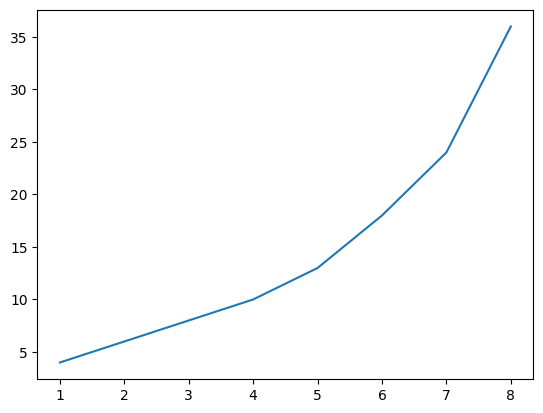

In [5]:
import matplotlib.pylab as plt

iterations_lambda: dict[int, float] = dict()
for i in range(1, 9):
    _lambda = i * 1.0 / 10
    iterations_lambda[i] = computePageRanks(damping=_lambda)
plt.plot(iterations_lambda.keys(), iterations_lambda.values())
plt.show()
# plot iterations_lambda
